In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
#导入相关库
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import math 
import xgboost as xgb
np.random.seed(2019)
from scipy.stats import skew
from scipy import stats

import statsmodels
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline
print("done")

done


In [3]:
#定义函数，得到训练和测试数据的合集data，并用train列0/1进行区分方便对比
def read_and_concat_dataset(training_path, test_path):
    train = pd.read_csv(training_path)
    #添加train列，并赋值1
    train['train'] = 1
    test = pd.read_csv(test_path)
    #添加train列，赋值0
    test['train'] = 0
    #连接train和test，appen将test所有行放在train末尾，返回一个新DataFrame
    data = train.append(test, ignore_index=True)
    return train, test, data
train, test, data = read_and_concat_dataset('/kaggle/input/titanic/test.csv', '/kaggle/input/titanic/train.csv')
#设置行索引名称
data = data.set_index('PassengerId')
data.shape

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


(1309, 12)

In [4]:
#查看前五条数据
data.head()
#survive的值为0和1,1代表存活，0代表死亡
#Pclass反应了乘客的经济地位，分为低中高三个层次
#SibSp和Parch分别代表兄弟姐妹、父母子女的人数
#Fare为票价
#Cabin为船舱号，目前可看出含有确实值
#Embarked为上船的港口，有C、Q、S三个港口
#其中，Survived/SibSp/Parch/Age/Fare为数值型数据，直观上讲可能会对存活率有影响，可以先对其进行相关性分析
#Embarked/sex为分类变量，后面可尝试进行编码处理

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,train
PassengerId,,,,,,,,,,,,
892,34.5,NaN,Q,7.8292,"Kelly, Mr. James",0,3,male,0,NaN,330911,1
893,47.0,NaN,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,3,female,1,NaN,363272,1
894,62.0,NaN,Q,9.6875,"Myles, Mr. Thomas Francis",0,2,male,0,NaN,240276,1
895,27.0,NaN,S,8.6625,"Wirz, Mr. Albert",0,3,male,0,NaN,315154,1
896,22.0,NaN,S,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,3,female,1,NaN,3101298,1


In [5]:
#查看数据整体统计参数
data.describe()
data.shape


(1309, 12)

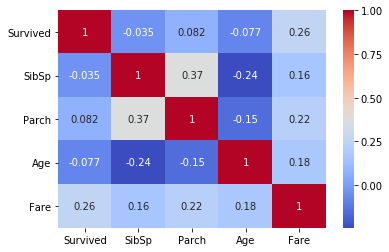

In [6]:
#查看数值间的相关性，DataFrame.corr()计算列的相关系数矩阵
g = sns.heatmap(data[["Survived", "SibSp", "Parch", "Age", "Fare"]].corr(),
                annot=True,cmap = "coolwarm"
               )
#可以看出数值变量间无明显的相关性，接下来可以单独考虑数值与存活与否这两个变量之间的关系


In [7]:
#定义函数，用来比较不同数值情况下的存活率
def compare_numerical_to_survive(data, variable, live='Survived'):
    result = data[[variable, live]][data[live].notnull()].groupby([variable], as_index=False).mean().sort_values(by=live, ascending=False)
    print(result)
   
    sns.barplot(x=variable,y=live,data=result)
    
    

   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000


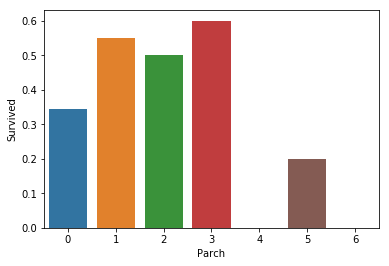

In [8]:
#乘客父母孩子的数量与乘客存活率
compare_numerical_to_survive(data, 'Parch')
#从图中可以看出有父母子女数量为3的乘客存活率最高

   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000


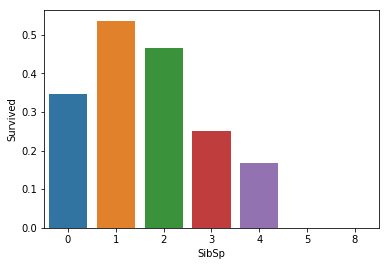

In [9]:
#查看兄弟姐妹数量与存活率
compare_numerical_to_survive(data, 'SibSp')
#可以看出有一个兄弟姐妹的乘客存活率最高

         Fare  Survived
247  512.3292       1.0
196   57.9792       1.0
89    13.8583       1.0
88    13.7917       1.0
86    13.4167       1.0
..        ...       ...
103   15.5500       0.0
180   47.1000       0.0
179   46.9000       0.0
178   42.4000       0.0
124   21.0750       0.0

[248 rows x 2 columns]


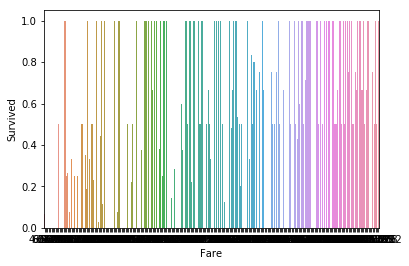

In [10]:
#查看费用与存活
compare_numerical_to_survive(data, 'Fare')


      Age  Survived
0    0.42       1.0
9    5.00       1.0
79  63.00       1.0
68  53.00       1.0
1    0.67       1.0
..    ...       ...
37  28.50       0.0
49  36.50       0.0
46  34.50       0.0
26  20.50       0.0
30  23.50       0.0

[88 rows x 2 columns]


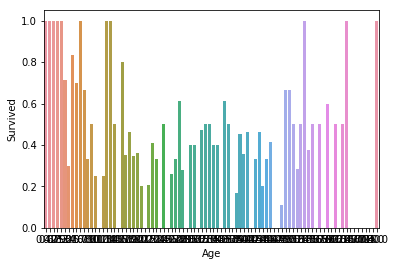

In [11]:
#查看年龄与存活
compare_numerical_to_survive(data, 'Age')

In [12]:
#接下来继续查看分类变量和存活的关系，定义函数计算变量取不同值时的存活率
def compare_variable_to_survive(data, variable, live='Survived'):
    result = data[[variable, live]][data[live].notnull()].groupby([variable], as_index=False).mean().sort_values(by=live, ascending=False)
    return result

In [13]:
#性别与存活
compare_variable_to_survive(data, 'Sex')
#女性存活率明显高于男性

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [14]:
data['Women'] = np.where(data.Sex=='female',1,0)
compare_variable_to_survive(data, 'Women')

,Women,Survived
1,1,0.742038
0,0,0.188908


In [15]:
#经济情况与存活
compare_variable_to_survive(data, 'Pclass')
#夫人存活率明显高于穷人

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [16]:
#登船港口和存活
compare_variable_to_survive(data, 'Embarked')
#0号港口存活率较高

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [17]:
#上述已有变量分析完后，可为后续的特征工程提供参考。
#在特征工程前，还要处理下缺失值
data.isnull().sum()
#年龄、船舱号、票价和登船港口均有缺失，其中年龄是很重要的变量必须填充，船舱号
#和票价缺失值较小，按众数填充即可；船舱号确实太多，考虑别的方法进行补充

Age          263
Cabin       1014
Embarked       2
Fare           1
Name           0
Parch          0
Pclass         0
Sex            0
SibSp          0
Survived     418
Ticket         0
train          0
Women          0
dtype: int64

In [18]:
#查看船票价格
data.groupby('Pclass')['Fare'].mean()


Pclass
1    87.508992
2    21.179196
3    13.302889
Name: Fare, dtype: float64

In [19]:
#用人数最多的三等均价填充
data.Fare = data.Fare.fillna(13)
data.shape

(1309, 13)

In [20]:
#查看港口
data.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [21]:
#用S填充
data.Embarked = data.Embarked.fillna('S')
data.shape

(1309, 13)

In [22]:
#对于船舱
data.Cabin.value_counts()
#可以看出船舱是以字母+数字的方式命名的，因此可以用Unkonwn来替换缺失值，并提取
#所有船舱的首字母从新命名

C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
F33                4
C22 C26            4
                  ..
T                  1
C95                1
A26                1
A16                1
E40                1
Name: Cabin, Length: 186, dtype: int64

In [23]:
data.Cabin = data.Cabin.fillna("Unknown")
data['Cabin'] = data['Cabin'].str[0]
data.shape

(1309, 13)

In [24]:
#查看船舱号按经济情况的分布
data.groupby('Pclass').Cabin.value_counts()

Pclass  Cabin
1       C         94
        U         67
        B         65
        D         40
        E         34
        A         22
        T          1
2       U        254
        F         13
        D          6
        E          4
3       U        693
        F          8
        G          5
        E          3
Name: Cabin, dtype: int64

In [25]:
#不同经济基础的U应当有不用的含义，因此将1中的U用C替换，2中的U用D替换，3中的U用G替换
data['Cabin'] = np.where((data.Pclass==1) & (data.Cabin=='U'),'C',
                                            np.where((data.Pclass==2) & (data.Cabin=='U'),'D',
                                                                        np.where((data.Pclass==3) & (data.Cabin=='U'),'G',
                                                                                                    np.where(data.Cabin=='T','C',data.Cabin))))
data.shape

(1309, 13)

In [26]:
#接下来是年龄填充，人名中带有称谓，如Mr,Mrs,可以提取这些值最为年龄填充的参考
#提取称谓
data['Title'] = data.Name.str.extract('([A-Za-z]+)\.', expand=False)
pd.crosstab(data['Title'], data['Sex'])
data = data.drop('Name',axis=1)
data.shape

(1309, 13)

In [27]:
data.Title
#可以看到有些称谓并不能代表身份，用otrher替换
data['Title'] = np.where((data.Title=='Capt') | (data.Title=='Countess') | (data.Title=='Don') | (data.Title=='Dona')
                        | (data.Title=='Jonkheer') | (data.Title=='Lady') | (data.Title=='Sir') | (data.Title=='Major') | (data.Title=='Rev') | (data.Title=='Col'),'Other',data.Title)

data['Title'] = data['Title'].replace('Ms','Miss')
data['Title'] = data['Title'].replace('Mlle','Miss')
data['Title'] = data['Title'].replace('Mme','Mrs')
data.shape

(1309, 13)

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


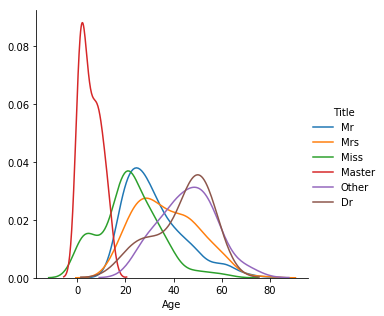

In [28]:
#查看新增变量与存活之间的关系
data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()
facet = sns.FacetGrid(data = data, hue = "Title", legend_out=True, size = 4.5)
facet = facet.map(sns.kdeplot, "Age")
facet.add_legend();

In [29]:
#查看称谓和年龄间的关系
data.groupby('Title').Age.mean()

Title
Dr        43.571429
Master     5.482642
Miss      21.824366
Mr        32.252151
Mrs       36.918129
Other     45.714286
Name: Age, dtype: float64

In [30]:
#采用称谓的均值填充对应确实的年龄
data['Age'] = np.where((data.Age.isnull()) & (data.Title=='Master'),5,
                        np.where((data.Age.isnull()) & (data.Title=='Miss'),22,
                                 np.where((data.Age.isnull()) & (data.Title=='Mr'),32,
                                          np.where((data.Age.isnull()) & (data.Title=='Mrs'),37,
                                                  np.where((data.Age.isnull()) & (data.Title=='Other'),45,
                                                           np.where((data.Age.isnull()) & (data.Title=='Dr'),44,data.Age))))))  
data.shape

(1309, 13)

In [31]:
#缺失值补充完毕后，进行特征工程，这里打算新增以下特征
#1.FamilySize，和兄弟姐妹、父母子女有关，描述家庭的大小
#2.Mother，拥有Mrs称谓，且有子女
#3.Free,那些免费获得船票的乘客
#4.TypeOfTicket，船票编号，前缀相同会在同一船舱
data['FamilySize'] = data.SibSp + data.Parch + 1
data['Mother'] = np.where((data.Title=='Mrs') & (data.Parch >0),1,0)
data['Free'] = np.where(data['Fare']==0, 1,0)
data = data.drop(['SibSp','Parch','Sex'],axis=1)
data.shape


(1309, 13)

In [32]:
import string
TypeOfTicket = []
for i in range(len(data.Ticket)):
    ticket = data.Ticket.iloc[i]
    for c in string.punctuation:
                ticket = ticket.replace(c,"")
                splited_ticket = ticket.split(" ")   
    if len(splited_ticket) == 1:
                TypeOfTicket.append('NO')
    else: 
                TypeOfTicket.append(splited_ticket[0])
            
data['TypeOfTicket'] = TypeOfTicket

data.TypeOfTicket.value_counts()
data['TypeOfTicket'] = np.where((data.TypeOfTicket!='NO') & (data.TypeOfTicket!='PC') & (data.TypeOfTicket!='CA') & 
                                (data.TypeOfTicket!='A5') & (data.TypeOfTicket!='SOTONOQ'),'other',data.TypeOfTicket)
data = data.drop('Ticket',axis=1)

   FamilySize  Survived
3           4  0.724138
2           3  0.578431
1           2  0.552795
6           7  0.333333
0           1  0.303538
4           5  0.200000
5           6  0.136364
7           8  0.000000
8          11  0.000000


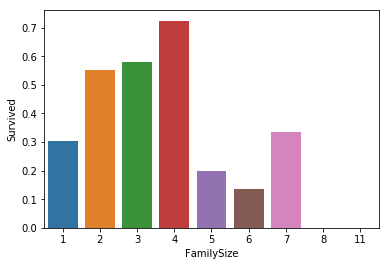

In [33]:
#家庭规模与存活
compare_numerical_to_survive(data, 'FamilySize')

In [34]:
#称谓与存活
compare_variable_to_survive(data, 'Title')

,Title,Survived
4,Mrs,0.793651
2,Miss,0.702703
1,Master,0.575000
0,Dr,0.428571
5,Other,0.312500
3,Mr,0.156673


In [35]:
#船舱与存活
compare_variable_to_survive(data, 'Cabin')

,Cabin,Survived
4,E,0.750000
1,B,0.744681
5,F,0.615385
2,C,0.540000
3,D,0.492537
0,A,0.466667
6,G,0.238095


In [36]:
#将年龄进行分箱
bins = [0,12,24,45,60,data.Age.max()]
labels = ['Child', 'Young Adult', 'Adult','Older Adult','Senior']
data["Age"] = pd.cut(data["Age"], bins, labels = labels)

In [37]:
#利用oneHot进行编码
data = pd.get_dummies(data)
data.shape

(1309, 35)

In [38]:
#开始训练模型,将采用决策树、随机森林、XGB分类进行建模
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(data[data.Survived.isnull()==False].drop('Survived',axis=1),data.Survived[data.Survived.isnull()==False],test_size=0.30, random_state=2019)


In [39]:

trainX.shape

(623, 34)

In [40]:
#利用Result存放结果
Results = pd.DataFrame({'Model': [],'Accuracy Score': []})

In [41]:
#决策树
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=4)
model.fit(trainX, trainY)
y_pred = model.predict(testX)
from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['DecisionTreeClassifier'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)]})
Results = Results.append(res)

In [42]:
pd.crosstab(testY, y_pred, rownames=['Real data'], colnames=['Predicted'])

Predicted,0.0,1.0
Real data,,
0.0,163,13
1.0,32,60


In [43]:
#随机森林
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=2500, max_depth=4)
model.fit(trainX, trainY)
y_pred = model.predict(testX)
from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['RandomForestClassifier'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)]})
Results = Results.append(res)

In [44]:
pd.crosstab(testY, y_pred, rownames=['Real data'], colnames=['Predicted'])

Predicted,0.0,1.0
Real data,,
0.0,160,16
1.0,27,65


In [45]:
#XGB
from xgboost.sklearn import XGBClassifier
model = XGBClassifier(learning_rate=0.001,n_estimators=2500,
                                max_depth=4, min_child_weight=0,
                                gamma=0, subsample=0.7,
                                colsample_bytree=0.7,
                                scale_pos_weight=1, seed=27,
                                reg_alpha=0.00006)
model.fit(trainX, trainY)
y_pred = model.predict(testX)
from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['XGBClassifier'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)]})
Results = Results.append(res)

In [46]:
pd.crosstab(testY, y_pred, rownames=['Real data'], colnames=['Predicted'])

Predicted,0.0,1.0
Real data,,
0.0,159,17
1.0,23,69


In [47]:
Results
#可以看出XGB效果最好

,Model,Accuracy Score
0,DecisionTreeClassifier,0.832090
0,RandomForestClassifier,0.839552
0,XGBClassifier,0.850746


In [48]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
trainX = data[data.Survived.isnull()==False].drop(['Survived','train'],axis=1)
trainY = data.Survived[data.Survived.isnull()==False]
testX = data[data.Survived.isnull()==True].drop(['Survived','train'],axis=1)
testX.shape

model = XGBClassifier(learning_rate=0.001,n_estimators=2500,
                                max_depth=4, min_child_weight=0,
                                gamma=0, subsample=0.7,
                                colsample_bytree=0.7,
                                scale_pos_weight=1, seed=27,
                                reg_alpha=0.00006)
model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.001, max_delta_step=0, max_depth=4,
              min_child_weight=0, missing=None, n_estimators=2500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=6e-05, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.7, verbosity=1)

In [49]:
test = data[data.train==1]
test['Survived'] = model.predict(testX).astype(int)
test = test.reset_index()
test[['PassengerId','Survived']].to_csv("submission_with_XGB.csv",index=False)
print("done!")


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


done!
